# Evaluation of data integration using scib and clustering metrics

In [1]:
import os
import glob
import warnings

import scanpy as sc
from anndata import AnnData
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# scib metrics
import scib

# Clustering metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA

# Load data

In [2]:
os.getcwd()

'/lustre/groups/ml01/workspace/christopher.lance/fae-single-cell/src/metrics'

In [3]:
os.chdir('../../../faes-single-cell/')

In [4]:
dataset = 'hanif_3groups_12k_group'
model_id = '2022-07-15_15-14-16_grid_hanif_3groups_12k_group_mb128_fd16_nbh20_calr0_bd2rec_adv'

In [5]:
adata_input = sc.read_h5ad('data/'+dataset+'.h5ad')
adata_embed = sc.read_h5ad('output/fae/'+dataset+'/'+model_id+'/reconstruction_epoch_1250.h5ad')

In [6]:
adata_input

AnnData object with n_obs × n_vars = 20040 × 14742
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'Phenotype', 'n_counts', 'ct_classes'
    var: 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'n_cells'
    uns: 'hvg'
    obsm: 'protein_expression', 'protein_expression_clr'
    layers: 'counts'

In [7]:
adata_embed

AnnData object with n_obs × n_vars = 20040 × 16
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'Phenotype', 'n_counts', 'ct_classes'
    uns: 'neighbors_backbone', 'neighbors_fiber', 'umap_backbone', 'umap_fiber'
    obsm: 'X_backbone', 'X_umap_backbone', 'X_umap_fiber'
    obsp: 'connectivities_backbone', 'connectivities_fiber', 'distances_backbone', 'distances_fiber'

In [8]:
adata_input.obsm['embed'] = adata_embed.X

## Prepare input data

In [9]:
sc.pp.pca(adata_input, use_highly_variable=True)
sc.pp.neighbors(adata_input)
sc.tl.umap(adata_input)

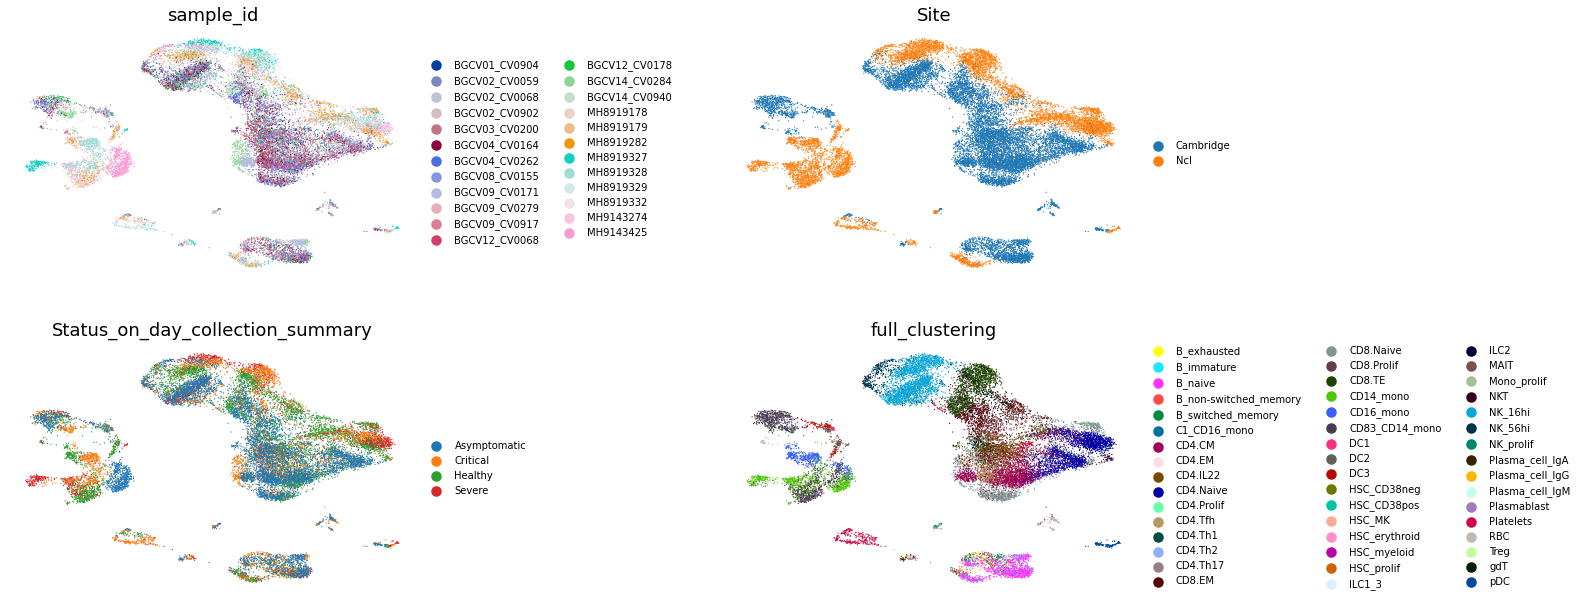

In [10]:
sc.pl.umap(adata_input, color=['sample_id', 'Site', 'Status_on_day_collection_summary', 'full_clustering'],
    frameon=False, ncols=2, legend_fontsize=10, wspace=0.6)

In [11]:
adata_embed.obsm['X_umap'] = adata_embed.obsm['X_umap_fiber']

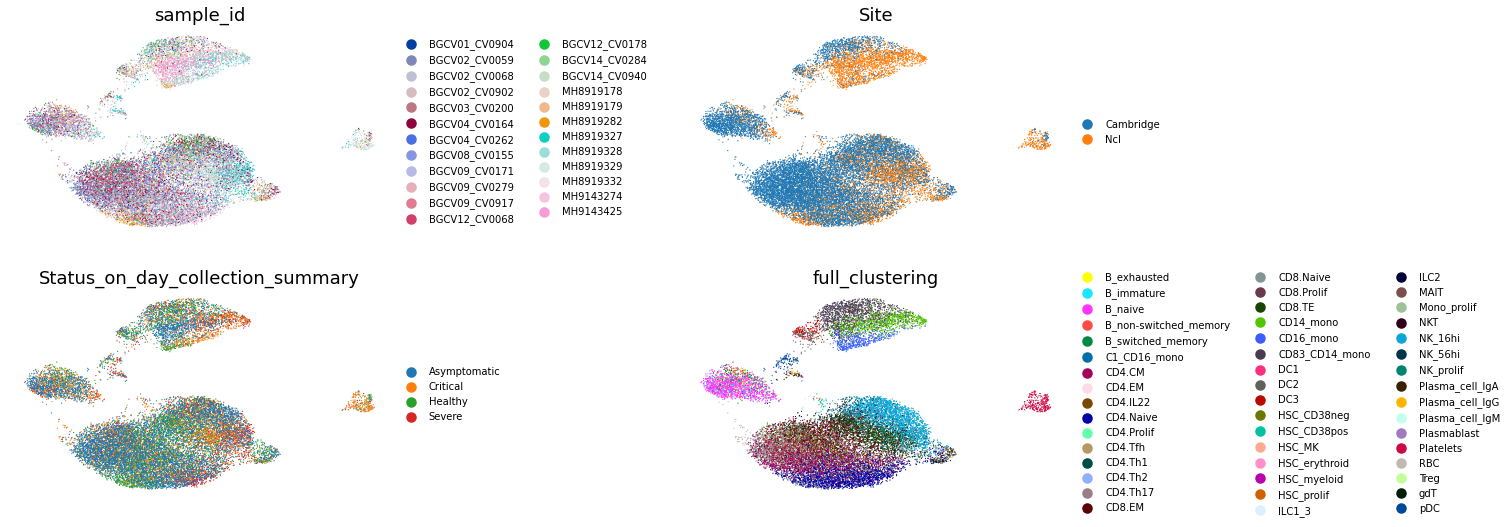

In [12]:
sc.pl.umap(adata_embed, color=['sample_id', 'Site', 'Status_on_day_collection_summary', 'full_clustering'],
    frameon=False, ncols=2, legend_fontsize=10, wspace=0.6)

In [13]:
adata_embed.obsm['X_umap'] = adata_embed.obsm['X_umap_backbone']

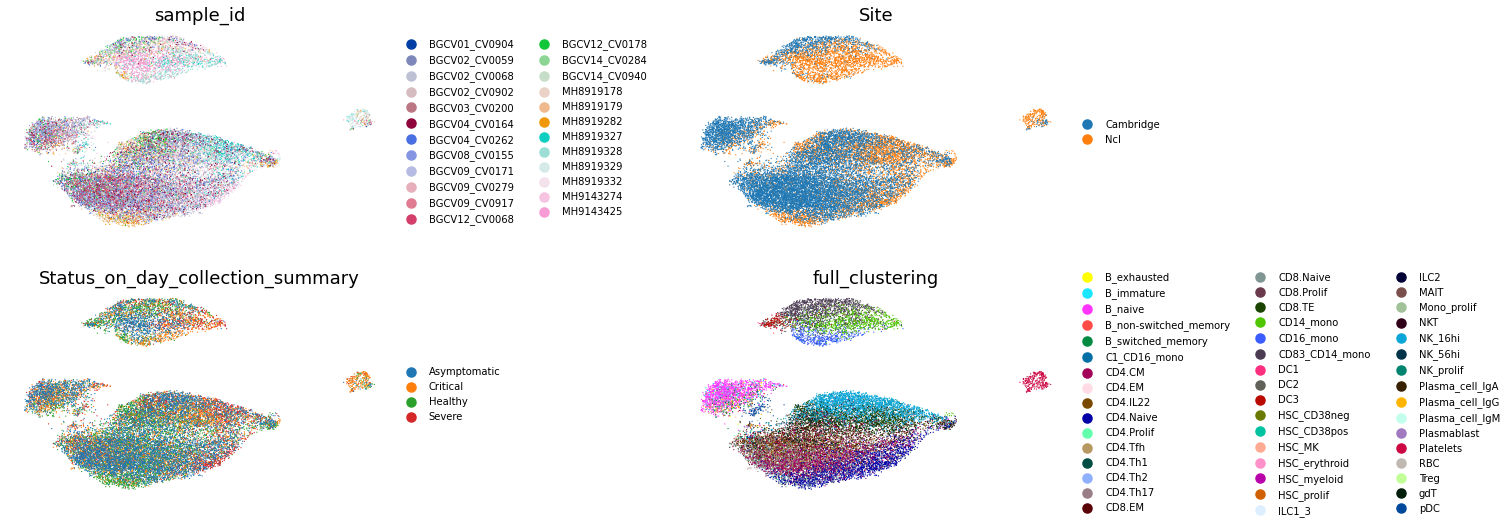

In [14]:
sc.pl.umap(adata_embed, color=['sample_id', 'Site', 'Status_on_day_collection_summary', 'full_clustering'],
    frameon=False, ncols=2, legend_fontsize=10, wspace=0.6)

## scib metrics - individual
Per metric to get timing and cell type specific details

In [15]:
%%time
clisi = scib.metrics.clisi_graph(adata_input,
                                 batch_key='sample_id',
                                 label_key='full_clustering')
clisi

CPU times: user 21.5 s, sys: 919 ms, total: 22.4 s
Wall time: 27.4 s


0.9867334063109824

In [16]:
%%time
ilisi = scib.metrics.ilisi_graph(adata_input,
                                 batch_key='sample_id')
ilisi

CPU times: user 21.5 s, sys: 1e+03 ms, total: 22.5 s
Wall time: 27.5 s


0.16621945749807712

In [17]:
%%time
aws_label = scib.metrics.silhouette(adata_input,
                                    group_key='full_clustering',
                                    embed='embed')
aws_label

CPU times: user 12.3 s, sys: 10.1 s, total: 22.4 s
Wall time: 7.47 s


0.48248787224292755

In [18]:
%%time
warnings.filterwarnings('ignore')
aws_batch= scib.metrics.silhouette_batch(adata_input,
                                         group_key='full_clustering',
                                         batch_key='sample_id',
                                         embed='embed')
aws_batch
warnings.filterwarnings('default')

mean silhouette per group:                        silhouette_score
group                                  
B_exhausted                    0.785976
B_immature                     0.793950
B_naive                        0.904810
B_non-switched_memory          0.796673
B_switched_memory              0.802726
C1_CD16_mono                   0.885143
CD14_mono                      0.884819
CD16_mono                      0.900554
CD4.CM                         0.905506
CD4.EM                         0.801781
CD4.IL22                       0.913733
CD4.Naive                      0.911868
CD4.Tfh                        0.881152
CD4.Th1                        0.854975
CD8.EM                         0.897494
CD8.Naive                      0.908004
CD8.Prolif                     0.844409
CD8.TE                         0.892205
CD83_CD14_mono                 0.896186
DC1                            0.779982
DC2                            0.863829
DC3                            0.834201
HSC_CD38neg  

In [19]:
%%time
aws_label = scib.metrics.isolated_labels(adata_input,
                                         label_key='full_clustering',
                                         batch_key='sample_id',
                                         embed='embed')
aws_label

isolated labels: no more than 1 batches per label
CD4.Th17: 0.0011337868480725624
HSC_MK: 0.03508771929824561
HSC_myeloid: 0.03508771929824561
Mono_prolif: 0.06349206349206349
CPU times: user 2min 45s, sys: 6.7 s, total: 2min 52s
Wall time: 2min 52s


0.03370032223415682

## scib metrics all together

In [20]:
%%time
warnings.filterwarnings('ignore')
batch_key='sample_id'
label_key='full_clustering'
embed='embed'
organism='human'

results = scib.metrics.metrics(adata_input,
                               adata_input,
                               batch_key=batch_key,
                               label_key=label_key,
                               embed=embed,
                               organism=organism,
                               
                               silhouette_=True,
                               pcr_=True,
                               nmi_=True,
                               ari_=True,
                               cell_cycle_=True,
                               lisi_graph_=True,
                               
                               isolated_labels_asw_=True,   #computationally expensive, not applicable for all data sets
                               isolated_labels_f1_=True,    #computationally expensive, not applicable for all data sets
                               
                               kBET_=False,           #requires R
                               trajectory_=False,     #no trajectory annotated
                               hvg_score_=False,      #often not informative
                               graph_conn_=False)     #often not informative
warnings.filterwarnings('default')

NMI...
ARI...
Silhouette score...
PC regression...
cell cycle effect...
Isolated labels F1...
Isolated labels ASW...
cLISI score...
iLISI score...
CPU times: user 7min 55s, sys: 3min 55s, total: 11min 51s
Wall time: 6min 32s


In [21]:
results

,0
NMI_cluster/label,0.646275
ARI_cluster/label,0.467332
ASW_label,0.482488
ASW_label/batch,0.854960
PCR_batch,0.358902
cell_cycle_conservation,0.778676
isolated_label_F1,0.033700
isolated_label_silhouette,0.539960
graph_conn,NaN
kBET,NaN


## Clustering metrics

In [22]:
adata_input

AnnData object with n_obs × n_vars = 20040 × 14742
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', 'Phenotype', 'n_counts', 'ct_classes', 'cluster'
    var: 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'n_cells'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'sample_id_colors', 'Site_colors', 'Status_on_day_collection_summary_colors', 'full_clustering_colors', 'louvain'
    obsm: 'protein_expression', 'protein_expression_clr', 'embed', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

### Logistic regression

In [23]:
# lrc function
def train_lrc(y, score_type, test_size = 0.2):

    res_df = pd.DataFrame(index = ['accuracy', 'f1'])

    for X,level in zip([X_rna, X_fiber, X_backbone],
                  ['X_rna', 'X_fiber', 'X_backbone']):

        print('Logistic regression on', level, 'with test size', test_size)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

        print('Training and calculating scores...')
        clf_lr = LogisticRegression(random_state=42,max_iter=200).fit(X_train, y_train)
        
        test_pred = clf_lr.predict(X_test)
        mean_acc_test = clf_lr.score(X_test, y_test)
        f1_test = f1_score(y_test, test_pred, average='weighted')

        lr_res_vec = [mean_acc_test, f1_test]

        res_df[level] = lr_res_vec
        
    if score_type=='batch_removal':
        res_df['backbone_score_batch'] = 1-(res_df['X_backbone']/res_df['X_rna'])
        res_df['fiber_score_batch'] = 1-(res_df['X_fiber']/res_df['X_rna'])
        
    elif score_type=='bio_conservation':
        res_df['backbone_score_label'] = res_df['X_backbone']/res_df['X_rna']
        res_df['fiber_score_label'] = res_df['X_fiber']/res_df['X_rna']
    
    else:
        print('Unknown score_type, please specify as batch_removal or bio_conservation.')
    
    return(res_df)

In [24]:
%%time
# define input levels
X_rna = adata_input.obsm['X_pca']
X_fiber = adata_embed.X
X_backbone = adata_embed.obsm['X_backbone']

y_label = adata_input.obs['full_clustering']
y_batch = adata_input.obs['sample_id']

# get metrics
lr_result_label = train_lrc(y_label, score_type='bio_conservation')
lr_result_batch = train_lrc(y_batch, score_type='batch_removal')

Logistic regression on X_rna with test size 0.2
Training and calculating scores...


/lustre/groups/ml01/workspace/christopher.lance/miniconda3/envs/fae_py38/lib/python3.8/site-packages/scikit_learn-1.1.1-py3.8-linux-x86_64.egg/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression on X_fiber with test size 0.2
Training and calculating scores...
Logistic regression on X_backbone with test size 0.2
Training and calculating scores...


/lustre/groups/ml01/workspace/christopher.lance/miniconda3/envs/fae_py38/lib/python3.8/site-packages/scikit_learn-1.1.1-py3.8-linux-x86_64.egg/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression on X_rna with test size 0.2
Training and calculating scores...


/lustre/groups/ml01/workspace/christopher.lance/miniconda3/envs/fae_py38/lib/python3.8/site-packages/scikit_learn-1.1.1-py3.8-linux-x86_64.egg/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic regression on X_fiber with test size 0.2
Training and calculating scores...
Logistic regression on X_backbone with test size 0.2
Training and calculating scores...
CPU times: user 2min, sys: 1min 10s, total: 3min 11s
Wall time: 49.9 s


In [25]:
lr_result_label

,X_rna,X_fiber,X_backbone,backbone_score_label,fiber_score_label
accuracy,0.792415,0.588074,0.486277,0.613665,0.742128
f1,0.782984,0.524695,0.387279,0.494619,0.670122


In [26]:
lr_result_batch

,X_rna,X_fiber,X_backbone,backbone_score_batch,fiber_score_batch
accuracy,0.548902,0.253743,0.221806,0.595909,0.537727
f1,0.547916,0.235643,0.189270,0.654564,0.569929


`score_label` and `score_batch` are consistent with the other scib metrics, such that they are 0 for worst batch removal/bio_conservation and 1 for best performance. Theoretically, they could become larger than 1 but very unlikely to happen.

### Random forest

In [27]:
# ranodm forest
def train_rfc(y, score_type, test_size = 0.2):

    res_df = pd.DataFrame(index = ['accuracy', 'f1'])

    for X,level in zip([X_rna, X_fiber, X_backbone],
                  ['X_rna', 'X_fiber', 'X_backbone']):

        print('Random forest on', level, 'with test size', test_size)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

        print('Training and calculating scores...')
        clf_rf = RandomForestClassifier(random_state=42,
                                            n_estimators = 200).fit(X_train, y_train)
        
        test_pred = clf_rf.predict(X_test)
        mean_acc_test = clf_rf.score(X_test, y_test)
        f1_test = f1_score(y_test, test_pred, average='weighted')

        rf_res_vec = [mean_acc_test, f1_test]

        res_df[level] = rf_res_vec
        
    if score_type=='batch_removal':
        res_df['backbone_score_batch'] = 1-(res_df['X_backbone']/res_df['X_rna'])
        res_df['fiber_score_batch'] = 1-(res_df['X_fiber']/res_df['X_rna'])
        
    elif score_type=='bio_conservation':
        res_df['backbone_score_label'] = res_df['X_backbone']/res_df['X_rna']
        res_df['fiber_score_label'] = res_df['X_fiber']/res_df['X_rna']
    
    else:
        print('Unknown score_type, please specify as batch_removal or bio_conservation.')
    
    return(res_df)

In [28]:
%%time
# define input levels
X_rna = adata_input.obsm['X_pca']
X_fiber = adata_embed.X
X_backbone = adata_embed.obsm['X_backbone']

y_label = adata_input.obs['full_clustering']
y_batch = adata_input.obs['sample_id']

# get metrics
rf_result_label = train_rfc(y_label, score_type='bio_conservation')
rf_result_batch = train_rfc(y_batch, score_type='batch_removal')

Random forest on X_rna with test size 0.2
Training and calculating scores...
Random forest on X_fiber with test size 0.2
Training and calculating scores...
Random forest on X_backbone with test size 0.2
Training and calculating scores...
Random forest on X_rna with test size 0.2
Training and calculating scores...
Random forest on X_fiber with test size 0.2
Training and calculating scores...
Random forest on X_backbone with test size 0.2
Training and calculating scores...
CPU times: user 3min 31s, sys: 2.93 s, total: 3min 34s
Wall time: 3min 34s


In [29]:
rf_result_label

,X_rna,X_fiber,X_backbone,backbone_score_label,fiber_score_label
accuracy,0.792665,0.607285,0.576098,0.726786,0.766132
f1,0.773272,0.565066,0.513442,0.663986,0.730747


In [30]:
rf_result_batch

,X_rna,X_fiber,X_backbone,backbone_score_batch,fiber_score_batch
accuracy,0.521707,0.282435,0.269711,0.483022,0.458632
f1,0.517500,0.272983,0.256686,0.503989,0.472496
